In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import scorer, make_scorer, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from collections import defaultdict, Counter

import matplotlib.pyplot as plt
import config
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook, tqdm, tnrange
tqdm.pandas()

from numba import jit

import lightgbm as lgb

%matplotlib inline
pd.set_option('display.max_columns', 100)

In [2]:
def expanding_count(x):
    exp_count = []
    count_dict = defaultdict(np.int32)
    for i in x:
        if i in count_dict:
            count_dict[i] += 1
            exp_count.append(count_dict[i])
        else:
            exp_count.append(1)
            count_dict[i] = 1
    return exp_count, count_dict

def mean_likelihood(df, cat_var, target, alpha = 0.5):
    P_c = df.groupby(cat_var)[target].transform('mean')
    P_global = df[target].mean()
    n_c = df.groupby(cat_var)[target].transform('count')
    enc = (P_c*n_c + P_global*alpha)/(n_c + alpha)
    temp = df[[cat_var]]
    temp['enc'] = enc
    return temp.groupby(cat_var).mean()

def label_enc(x):
    values = x.unique()
    lb_enc = defaultdict(np.int32)
    for i, v in enumerate(values):
        lb_enc[v] = i
    return lb_enc, values

def one_hot_enc(x):
    values = x.unique()
    values_dict = {v:i for i, v in enumerate(values)}
    one_hot_enc = np.zeros(shape = (len(x), len(values)))
    for idx, v in enumerate(x):
        one_hot_enc[idx, values_dict[v]] = 1
    return one_hot_enc

@jit
def prev_view(user_id, DateTime):
    user_id_dict = defaultdict()
    prev_view = np.zeros(len(user_id))
    for i, (u, t) in enumerate(zip(user_id, DateTime)):
        if u in user_id_dict:
            prev_view[i] = (t - user_id_dict[u])
            user_id_dict[u] = t
        else:
            prev_view[i] = 0
            user_id_dict[u] = t
    prev_view = prev_view/10**10
    return prev_view

@jit
def next_view(user_id, DateTime):
    user_id_dict = defaultdict()
    next_view = np.zeros(len(user_id))
    for i, (u, t) in enumerate(zip(user_id, DateTime)):
        if i == 0:
            continue
        if u in user_id_dict:
            next_view[i-1] = (t - user_id_dict[u])
            user_id_dict[u] = t
        else:
            next_view[i-1] = 0
            user_id_dict[u] = t
    next_view = next_view/10**10
    return next_view

def expanding_click_count(x, y):
    exp_count = []
    count_dict = defaultdict(np.int32)
    for i, j in zip(x, y):
        if i in count_dict:
            if j == 1:
                count_dict[i] += 1
                exp_count.append(count_dict[i])
            else:
                exp_count.append(count_dict[i])
        else:
            if j == 1:
                exp_count.append(1)
                count_dict[i] = 1
            else:
                exp_count.append(0)
                count_dict[i] = 0
    return exp_count, count_dict

In [3]:
def load_data():
    df_train = pd.read_csv(config.train_path)
    df_test = pd.read_csv(config.test_path)
    
    df_data = pd.concat([df_train, df_test])
    cat_vars = ['product', 'campaign_id', 'webpage_id', 'product_category_1', 'product_category_2',
               'user_group_id', 'gender', 'age_level', 'user_depth', 'city_development_index', 'var_1']
    
    for cat in cat_vars:
        df_data[cat].fillna(-999, inplace = True)
    
    df_data['product_category'] = df_data['product_category_1'].astype(str)+'_'+ \
                                df_data['product_category_2'].astype(str)
    
    cat_vars.remove('product_category_1')
    cat_vars.remove('product_category_2')
    cat_vars.append('product_category')
    
    # getting hour features
    df_data['DateTime'] = pd.to_datetime(df_data['DateTime'])
    df_data['dayofweek'] = df_data['DateTime'].dt.dayofweek
    
    for var in cat_vars:
        lb_dict, _ = label_enc(df_data[var])
        df_data[f'lb_{var}'] = df_data[var].map(lb_dict)
    
    # getting count features
    df_data['user_id_count'] = df_data['user_id'].map(Counter(df_data['user_id']))
    exp_count, _ = expanding_count(df_data['user_id'])
    df_data['user_id_exp_count'] = exp_count
    
    df_data['user_wp'] = df_data['user_id'].astype(str)+'_'+df_data['webpage_id'].astype(str)
    df_data['user_wp_count'] = df_data['user_wp'].map(Counter(df_data['user_wp']))
    exp_count, _ = expanding_count(df_data['user_wp'])
    df_data['user_wp_exp_count'] = exp_count
    
    df_data['user_product'] = df_data['user_id'].astype(str)+'_'+df_data['product'].astype(str)
    df_data['user_product_count'] = df_data['user_product'].map(Counter(df_data['user_product']))
    
    df_data['product_wp'] = df_data['product'].astype(str) + '_' + df_data['webpage_id'].astype(str)
    df_data['product_wp_count'] = df_data['product_wp'].map(Counter(df_data['product_wp']))
    
    df_data['user_wp_product'] = df_data['user_id'].astype(str)+ '_' + df_data['product_wp']
    df_data['user_wp_product_count'] = df_data['user_wp_product'].map(Counter(df_data['user_wp_product']))
    exp_count, _ = expanding_count(df_data['user_wp_product'])
    df_data['user_wp_product_exp_count'] = exp_count
    
    temp = df_data.groupby(['user_id', 'webpage_id']).size().unstack().fillna(0)
    df_data = df_data.join(temp, on = 'user_id', how = 'left')
    
    temp = df_data.groupby(['user_id', 'dayofweek']).size().unstack().fillna(0)
    df_data = df_data.join(temp, on = 'user_id', how = 'left')
    
    # getting prev_view features
    df_data['prev_view'] = prev_view(df_data['user_id'].values, 
                                     pd.to_datetime(df_data['DateTime'], unit='ms').values)
    df_data['prev_wp_view'] = prev_view((df_data['user_id'].astype(str)+'_'+df_data['webpage_id'].astype(str)).values,
                                       pd.to_datetime(df_data['DateTime'], unit='ms').values)
    df_data['prev_product_view'] = prev_view((df_data['user_id'].astype(str)+'_'+ \
                                              df_data['product'].astype(str)).values,
                                       pd.to_datetime(df_data['DateTime'], unit='ms').values)
    df_data['user_wp_product_view'] = prev_view((df_data['user_id'].astype(str)+'_'+ \
                                                 df_data['product'].astype(str)+'_'+ \
                                                df_data['webpage_id'].astype(str)).values,
                                       pd.to_datetime(df_data['DateTime'], unit='ms').values)
    
    df_data['count_ratio'] = df_data['user_id_exp_count']/ df_data['user_id_count']
    
    # splitting into train and test
    df_train = df_data.loc[df_data.is_click.notna()]
    df_test = df_data.loc[df_data.is_click.isna()]
    
    
    # getting mean encoding features
    cvlist = list(KFold(n_splits = 10, random_state = 1).split(df_train))
    for var in cat_vars + ['user_id', 'product_wp']:
        mean_enc_var = np.zeros(len(df_train))
        for tr_idx, val_idx in cvlist:
            X_tr, X_val = df_train.loc[tr_idx], df_train.loc[val_idx]
            X_tr_mean = mean_likelihood(X_tr, var, 'is_click')
            mean_enc_var[val_idx] = X_val[var].map(X_tr_mean['enc'])
            df_train[f'mean_enc_{var}'] = mean_enc_var
        df_train[f'mean_enc_{var}'] = df_train[f'mean_enc_{var}'].fillna(df_train[f'mean_enc_{var}'].mean())
        df_test[f'mean_enc_{var}'] = df_test[var].map(mean_likelihood(df_train, 
                                                                        var, 'is_click')['enc'])
        df_test[f'mean_enc_{var}'] = df_test[f'mean_enc_{var}'].fillna(df_train[f'mean_enc_{var}'].mean())
        
    
    return df_train, df_test

In [4]:
def get_next_view(df):
    df['next_view'] = df.groupby('user_id')['prev_view'].shift(-1).values
    df['next_view'] = df['next_view'].fillna(-9999)
    
    df['next_wp_view'] = df.groupby('user_id')['prev_wp_view'].shift(-1).values
    df['next_wp_view'] = df['next_wp_view'].fillna(-9999)

    df['next_product_view'] = df.groupby('user_id')['prev_product_view'].shift(-1).values
    df['next_product_view'] = df['next_product_view'].fillna(-9999)

    df['next_user_wp_product_view'] = df.groupby('user_id')['user_wp_product_view'].shift(-1).values
    df['next_user_wp_product_view'] = df['next_user_wp_product_view'].fillna(-9999)
    
    return df

In [5]:
def val_check(estimator, df_train, feats, val_day = 5,**est_kwargs):
    est = estimator.set_params(**est_kwargs)
    X_tr, y_tr = df_train.loc[df_train.DateTime.dt.day < val_day+1], \
                df_train.loc[df_train.DateTime.dt.day < val_day+1, 'is_click']
    X_val, y_val = df_train.loc[df_train.DateTime.dt.day > val_day], \
                df_train.loc[df_train.DateTime.dt.day > val_day, 'is_click']
    
    feats = feats + ['next_view', 'next_user_wp_product_view', 'next_wp_view',
                                       'next_product_view']
    X_tr = get_next_view(X_tr)
    X_val = get_next_view(X_val)
    
    X_tr = X_tr[feats]
    X_val = X_val[feats]
    
    print(X_tr.shape)
    est.fit(X_tr, y_tr, 
            eval_set = [(X_tr, y_tr), (X_val, y_val)],
            eval_metric = 'logloss',
               verbose=100,
            early_stopping_rounds=50)
    y_val_preds = est.predict_proba(X_val, num_iteration =clf.best_iteration_)[:, 1]
    print(f'AUC score: {roc_auc_score(y_val, y_val_preds)}')
    
    imp_df = pd.DataFrame()
    imp_df['feature'] = feats
    imp_df['gain'] = est.feature_importances_
    plt.figure(figsize=(8, 8))
    imp_df = imp_df.sort_values(by = 'gain', ascending = False)
    sns.barplot(y = 'feature', x = 'gain', data= imp_df)
    plt.tight_layout()
    plt.show()
    
    return y_val_preds

In [6]:
def get_feats():
    feats = [str(c) for c in df_train.columns if ('lb_' in str(c)) or ('mean_enc_' in str(c)) or \
             ('view' in str(c)) or ('count' in str(c))]
    feats = [c for c in feats if c not in ['lb_gender', 'lb_user_depth', 'lb_user_group_id', 
                                           'lb_city_development_index', 'mean_enc_city_development_index', 
                                           'minute', 'lb_age_level', 'mean_enc_gender',
                                          'mean_enc_var_1', 'mean_enc_user_depth', 'lb_webpage_id',
                                          'lb_product']]
    return feats

In [7]:
df_train, df_test = load_data()

In [8]:
df_train.head()

,DateTime,age_level,campaign_id,city_development_index,gender,is_click,product,product_category_1,product_category_2,session_id,user_depth,user_group_id,user_id,var_1,webpage_id,product_category,dayofweek,lb_product,lb_campaign_id,lb_webpage_id,lb_user_group_id,lb_gender,lb_age_level,lb_user_depth,lb_city_development_index,lb_var_1,lb_product_category,user_id_count,user_id_exp_count,user_wp,user_wp_count,user_wp_exp_count,user_product,user_product_count,product_wp,product_wp_count,user_wp_product,user_wp_product_count,user_wp_product_exp_count,1734,6970,11085,13787,28529,45962,51181,53587,60305,0,1,2,3,4,5,6,prev_view,prev_wp_view,prev_product_view,user_wp_product_view,count_ratio,mean_enc_product,mean_enc_campaign_id,mean_enc_webpage_id,mean_enc_user_group_id,mean_enc_gender,mean_enc_age_level,mean_enc_user_depth,mean_enc_city_development_index,mean_enc_var_1,mean_enc_product_category,mean_enc_user_id,mean_enc_product_wp
0,2017-07-02 00:00:00,4.0,359520,3.0,Female,0.0,C,4,-999.0,140690,3.0,10.0,858557,0,13787,4_-999.0,6,0,0,0,0,0,0,0,0,0,0,4,1,858557_13787,2,1,858557_C,2,C_13787,96652,858557_C_13787,2,1,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.250000,0.068244,0.058234,0.053682,0.055453,0.064384,0.058370,0.067117,0.065465,0.064693,0.062087,0.022381,0.048510
1,2017-07-02 00:00:00,2.0,105960,-999.0,Female,0.0,C,5,-999.0,333291,2.0,8.0,243253,0,11085,5_-999.0,6,0,1,1,1,0,1,1,1,0,1,5,1,243253_11085,1,1,243253_C,5,C_11085,11088,243253_C_11085,1,1,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.200000,0.068244,0.071006,0.071006,0.063660,0.064384,0.069993,0.064435,0.066936,0.064693,0.047364,0.062425,0.073226
2,2017-07-02 00:00:00,2.0,359520,-999.0,Female,0.0,C,4,-999.0,129781,2.0,8.0,243253,0,13787,4_-999.0,6,0,0,0,1,0,1,1,1,0,0,5,2,243253_13787,4,1,243253_C,5,C_13787,96652,243253_C_13787,4,1,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.400000,0.068244,0.058234,0.053682,0.063660,0.064384,0.069993,0.064435,0.066936,0.064693,0.062087,0.062425,0.048510
3,2017-07-02 00:00:00,3.0,359520,2.0,Male,0.0,I,3,-999.0,464848,3.0,3.0,1097446,1,13787,3_-999.0,6,1,0,0,2,1,2,0,2,1,2,24,1,1097446_13787,13,1,1097446_I,3,I_13787,15018,1097446_I_13787,3,1,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,11.0,8.0,6.0,0.0,2.0,1.0,1.0,6.0,0.0,0.0,0.0,0.0,0.041667,0.063438,0.058234,0.053682,0.064845,0.067420,0.064717,0.067117,0.069238,0.070490,0.083340,0.001918,0.057999
4,2017-07-02 00:01:00,2.0,405490,2.0,Male,0.0,C,3,-999.0,90569,3.0,2.0,663656,1,60305,3_-999.0,6,0,2,2,3,1,1,0,2,1,2,11,1,663656_60305,3,1,663656_C,2,C_60305,74854,663656_C_60305,2,1,0.0,0.0,0.0,0.0,7.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,8.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.090909,0.068244,0.089180,0.089180,0.070274,0.067420,0.069993,0.067117,0.069238,0.070490,0.083340,0.193673,0.092557


In [9]:
df_historical_logs = pd.read_csv('../input/train_amex/historical_user_logs.csv')
print(f'shape of historical logs is {df_historical_logs.shape}')

shape of historical logs is (24287534, 4)


In [10]:
df_historical_logs['DateTime'] = pd.to_datetime(df_historical_logs['DateTime'])
df_historical_logs['dayofweek'] = df_historical_logs.DateTime.dt.dayofweek

In [11]:
temp = df_historical_logs.groupby(['user_id', 
                                   'product'])['action'].agg({lambda x: np.sum([1 for v in x if v == 'view'])}).unstack()
temp = temp.fillna(0)
temp = temp.reset_index()
temp.columns = ['user_id', 'product_A', 'product_B', 'product_C', 'product_D', 'product_E',
               'product_F', 'product_G', 'product_H', 'product_I', 'product_J']
df_train = df_train.join(temp.set_index('user_id'), on = 'user_id', how = 'left')
df_test = df_test.join(temp.set_index('user_id'), on = 'user_id', how = 'left')
df_train.head()

,DateTime,age_level,campaign_id,city_development_index,gender,is_click,product,product_category_1,product_category_2,session_id,user_depth,user_group_id,user_id,var_1,webpage_id,product_category,dayofweek,lb_product,lb_campaign_id,lb_webpage_id,lb_user_group_id,lb_gender,lb_age_level,lb_user_depth,lb_city_development_index,lb_var_1,lb_product_category,user_id_count,user_id_exp_count,user_wp,user_wp_count,user_wp_exp_count,user_product,user_product_count,product_wp,product_wp_count,user_wp_product,user_wp_product_count,user_wp_product_exp_count,1734,6970,11085,13787,28529,45962,51181,53587,60305,0,1,2,3,4,5,6,prev_view,prev_wp_view,prev_product_view,user_wp_product_view,count_ratio,mean_enc_product,mean_enc_campaign_id,mean_enc_webpage_id,mean_enc_user_group_id,mean_enc_gender,mean_enc_age_level,mean_enc_user_depth,mean_enc_city_development_index,mean_enc_var_1,mean_enc_product_category,mean_enc_user_id,mean_enc_product_wp,product_A,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J
0,2017-07-02 00:00:00,4.0,359520,3.0,Female,0.0,C,4,-999.0,140690,3.0,10.0,858557,0,13787,4_-999.0,6,0,0,0,0,0,0,0,0,0,0,4,1,858557_13787,2,1,858557_C,2,C_13787,96652,858557_C_13787,2,1,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.250000,0.068244,0.058234,0.053682,0.055453,0.064384,0.058370,0.067117,0.065465,0.064693,0.062087,0.022381,0.048510,0.0,80.0,5.0,25.0,436.0,40.0,10.0,25.0,6.0,0.0
1,2017-07-02 00:00:00,2.0,105960,-999.0,Female,0.0,C,5,-999.0,333291,2.0,8.0,243253,0,11085,5_-999.0,6,0,1,1,1,0,1,1,1,0,1,5,1,243253_11085,1,1,243253_C,5,C_11085,11088,243253_C_11085,1,1,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.200000,0.068244,0.071006,0.071006,0.063660,0.064384,0.069993,0.064435,0.066936,0.064693,0.047364,0.062425,0.073226,0.0,12.0,11.0,0.0,0.0,3.0,1.0,35.0,0.0,0.0
2,2017-07-02 00:00:00,2.0,359520,-999.0,Female,0.0,C,4,-999.0,129781,2.0,8.0,243253,0,13787,4_-999.0,6,0,0,0,1,0,1,1,1,0,0,5,2,243253_13787,4,1,243253_C,5,C_13787,96652,243253_C_13787,4,1,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.400000,0.068244,0.058234,0.053682,0.063660,0.064384,0.069993,0.064435,0.066936,0.064693,0.062087,0.062425,0.048510,0.0,12.0,11.0,0.0,0.0,3.0,1.0,35.0,0.0,0.0
3,2017-07-02 00:00:00,3.0,359520,2.0,Male,0.0,I,3,-999.0,464848,3.0,3.0,1097446,1,13787,3_-999.0,6,1,0,0,2,1,2,0,2,1,2,24,1,1097446_13787,13,1,1097446_I,3,I_13787,15018,1097446_I_13787,3,1,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,11.0,8.0,6.0,0.0,2.0,1.0,1.0,6.0,0.0,0.0,0.0,0.0,0.041667,0.063438,0.058234,0.053682,0.064845,0.067420,0.064717,0.067117,0.069238,0.070490,0.083340,0.001918,0.057999,0.0,8.0,5.0,1.0,0.0,0.0,5.0,14.0,8.0,0.0
4,2017-07-02 00:01:00,2.0,405490,2.0,Male,0.0,C,3,-999.0,90569,3.0,2.0,663656,1,60305,3_-999.0,6,0,2,2,3,1,1,0,2,1,2,11,1,663656_60305,3,1,663656_C,2,C_60305,74854,663656_C_60305,2,1,0.0,0.0,0.0,0.0,7.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,8.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.090909,0.068244,0.089180,0.089180,0.070274,0.067420,0.069993,0.067117,0.069238,0.070490,0.083340,0.193673,0.092557,22.0,12.0,3.0,0.0,0.0,3.0,0.0,15.0,2.0,0.0


In [12]:
temp = df_historical_logs.groupby('user_id').size().reset_index()
temp.columns = ['user_id', 'count']
df_train = df_train.join(temp.set_index('user_id'), on = 'user_id', how = 'left')
df_test = df_test.join(temp.set_index('user_id'), on = 'user_id', how = 'left')
df_train.head()

,DateTime,age_level,campaign_id,city_development_index,gender,is_click,product,product_category_1,product_category_2,session_id,user_depth,user_group_id,user_id,var_1,webpage_id,product_category,dayofweek,lb_product,lb_campaign_id,lb_webpage_id,lb_user_group_id,lb_gender,lb_age_level,lb_user_depth,lb_city_development_index,lb_var_1,lb_product_category,user_id_count,user_id_exp_count,user_wp,user_wp_count,user_wp_exp_count,user_product,user_product_count,product_wp,product_wp_count,user_wp_product,user_wp_product_count,user_wp_product_exp_count,1734,6970,11085,13787,28529,45962,51181,53587,60305,0,1,2,3,4,5,6,prev_view,prev_wp_view,prev_product_view,user_wp_product_view,count_ratio,mean_enc_product,mean_enc_campaign_id,mean_enc_webpage_id,mean_enc_user_group_id,mean_enc_gender,mean_enc_age_level,mean_enc_user_depth,mean_enc_city_development_index,mean_enc_var_1,mean_enc_product_category,mean_enc_user_id,mean_enc_product_wp,product_A,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J,count
0,2017-07-02 00:00:00,4.0,359520,3.0,Female,0.0,C,4,-999.0,140690,3.0,10.0,858557,0,13787,4_-999.0,6,0,0,0,0,0,0,0,0,0,0,4,1,858557_13787,2,1,858557_C,2,C_13787,96652,858557_C_13787,2,1,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.250000,0.068244,0.058234,0.053682,0.055453,0.064384,0.058370,0.067117,0.065465,0.064693,0.062087,0.022381,0.048510,0.0,80.0,5.0,25.0,436.0,40.0,10.0,25.0,6.0,0.0,627.0
1,2017-07-02 00:00:00,2.0,105960,-999.0,Female,0.0,C,5,-999.0,333291,2.0,8.0,243253,0,11085,5_-999.0,6,0,1,1,1,0,1,1,1,0,1,5,1,243253_11085,1,1,243253_C,5,C_11085,11088,243253_C_11085,1,1,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.200000,0.068244,0.071006,0.071006,0.063660,0.064384,0.069993,0.064435,0.066936,0.064693,0.047364,0.062425,0.073226,0.0,12.0,11.0,0.0,0.0,3.0,1.0,35.0,0.0,0.0,62.0
2,2017-07-02 00:00:00,2.0,359520,-999.0,Female,0.0,C,4,-999.0,129781,2.0,8.0,243253,0,13787,4_-999.0,6,0,0,0,1,0,1,1,1,0,0,5,2,243253_13787,4,1,243253_C,5,C_13787,96652,243253_C_13787,4,1,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.400000,0.068244,0.058234,0.053682,0.063660,0.064384,0.069993,0.064435,0.066936,0.064693,0.062087,0.062425,0.048510,0.0,12.0,11.0,0.0,0.0,3.0,1.0,35.0,0.0,0.0,62.0
3,2017-07-02 00:00:00,3.0,359520,2.0,Male,0.0,I,3,-999.0,464848,3.0,3.0,1097446,1,13787,3_-999.0,6,1,0,0,2,1,2,0,2,1,2,24,1,1097446_13787,13,1,1097446_I,3,I_13787,15018,1097446_I_13787,3,1,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,11.0,8.0,6.0,0.0,2.0,1.0,1.0,6.0,0.0,0.0,0.0,0.0,0.041667,0.063438,0.058234,0.053682,0.064845,0.067420,0.064717,0.067117,0.069238,0.070490,0.083340,0.001918,0.057999,0.0,8.0,5.0,1.0,0.0,0.0,5.0,14.0,8.0,0.0,43.0
4,2017-07-02 00:01:00,2.0,405490,2.0,Male,0.0,C,3,-999.0,90569,3.0,2.0,663656,1,60305,3_-999.0,6,0,2,2,3,1,1,0,2,1,2,11,1,663656_60305,3,1,663656_C,2,C_60305,74854,663656_C_60305,2,1,0.0,0.0,0.0,0.0,7.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,8.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.090909,0.068244,0.089180,0.089180,0.070274,0.067420,0.069993,0.067117,0.069238,0.070490,0.083340,0.193673,0.092557,22.0,12.0,3.0,0.0,0.0,3.0,0.0,15.0,2.0,0.0,60.0


In [13]:
tmep = df_historical_logs.groupby(['user_id', 'DateTime']).size().reset_index()
tmep.columns = ['user_id', 'DateTime', 'same_user_time_count']

temp = tmep.groupby('user_id').agg({"same_user_time_count": ['var', 'mean']}).reset_index()
temp.columns = ['user_id', 'same_user_time_count_var', 'same_user_time_count_mean']
temp.head()

,user_id,same_user_time_count_var,same_user_time_count_mean
0,4,0.000000,1.000000
1,19,1.175258,1.714286
2,25,0.687805,1.634146
3,26,0.653968,1.444444
4,30,0.629252,1.469388


In [14]:
df_train = df_train.join(temp.set_index('user_id'), on = 'user_id', how = 'left')
df_test = df_test.join(temp.set_index('user_id'), on = 'user_id', how = 'left')
df_train['same_user_time_count_var'] = df_train['same_user_time_count_var'].fillna(0)
df_test['same_user_time_count_var'] = df_test['same_user_time_count_var'].fillna(0)

df_train['same_user_time_count_mean'] = df_train['same_user_time_count_mean'].fillna(0)
df_test['same_user_time_count_mean'] = df_test['same_user_time_count_mean'].fillna(0)
df_train.head()

,DateTime,age_level,campaign_id,city_development_index,gender,is_click,product,product_category_1,product_category_2,session_id,user_depth,user_group_id,user_id,var_1,webpage_id,product_category,dayofweek,lb_product,lb_campaign_id,lb_webpage_id,lb_user_group_id,lb_gender,lb_age_level,lb_user_depth,lb_city_development_index,lb_var_1,lb_product_category,user_id_count,user_id_exp_count,user_wp,user_wp_count,user_wp_exp_count,user_product,user_product_count,product_wp,product_wp_count,user_wp_product,user_wp_product_count,user_wp_product_exp_count,1734,6970,11085,13787,28529,45962,51181,53587,60305,0,1,2,3,4,5,6,prev_view,prev_wp_view,prev_product_view,user_wp_product_view,count_ratio,mean_enc_product,mean_enc_campaign_id,mean_enc_webpage_id,mean_enc_user_group_id,mean_enc_gender,mean_enc_age_level,mean_enc_user_depth,mean_enc_city_development_index,mean_enc_var_1,mean_enc_product_category,mean_enc_user_id,mean_enc_product_wp,product_A,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J,count,same_user_time_count_var,same_user_time_count_mean
0,2017-07-02 00:00:00,4.0,359520,3.0,Female,0.0,C,4,-999.0,140690,3.0,10.0,858557,0,13787,4_-999.0,6,0,0,0,0,0,0,0,0,0,0,4,1,858557_13787,2,1,858557_C,2,C_13787,96652,858557_C_13787,2,1,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.250000,0.068244,0.058234,0.053682,0.055453,0.064384,0.058370,0.067117,0.065465,0.064693,0.062087,0.022381,0.048510,0.0,80.0,5.0,25.0,436.0,40.0,10.0,25.0,6.0,0.0,627.0,12.635294,3.666667
1,2017-07-02 00:00:00,2.0,105960,-999.0,Female,0.0,C,5,-999.0,333291,2.0,8.0,243253,0,11085,5_-999.0,6,0,1,1,1,0,1,1,1,0,1,5,1,243253_11085,1,1,243253_C,5,C_11085,11088,243253_C_11085,1,1,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.200000,0.068244,0.071006,0.071006,0.063660,0.064384,0.069993,0.064435,0.066936,0.064693,0.047364,0.062425,0.073226,0.0,12.0,11.0,0.0,0.0,3.0,1.0,35.0,0.0,0.0,62.0,6.632035,2.818182
2,2017-07-02 00:00:00,2.0,359520,-999.0,Female,0.0,C,4,-999.0,129781,2.0,8.0,243253,0,13787,4_-999.0,6,0,0,0,1,0,1,1,1,0,0,5,2,243253_13787,4,1,243253_C,5,C_13787,96652,243253_C_13787,4,1,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.400000,0.068244,0.058234,0.053682,0.063660,0.064384,0.069993,0.064435,0.066936,0.064693,0.062087,0.062425,0.048510,0.0,12.0,11.0,0.0,0.0,3.0,1.0,35.0,0.0,0.0,62.0,6.632035,2.818182
3,2017-07-02 00:00:00,3.0,359520,2.0,Male,0.0,I,3,-999.0,464848,3.0,3.0,1097446,1,13787,3_-999.0,6,1,0,0,2,1,2,0,2,1,2,24,1,1097446_13787,13,1,1097446_I,3,I_13787,15018,1097446_I_13787,3,1,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,11.0,8.0,6.0,0.0,2.0,1.0,1.0,6.0,0.0,0.0,0.0,0.0,0.041667,0.063438,0.058234,0.053682,0.064845,0.067420,0.064717,0.067117,0.069238,0.070490,0.083340,0.001918,0.057999,0.0,8.0,5.0,1.0,0.0,0.0,5.0,14.0,8.0,0.0,43.0,0.321747,1.264706
4,2017-07-02 00:01:00,2.0,405490,2.0,Male,0.0,C,3,-999.0,90569,3.0,2.0,663656,1,60305,3_-999.0,6,0,2,2,3,1,1,0,2,1,2,11,1,663656_60305,3,1,663656_C,2,C_60305,74854,663656_C_60305,2,1,0.0,0.0,0.0,0.0,7.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,8.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.090909,0.068244,0.089180,0.089180,0.070274,0.067420,0.069993,0.067117,0.069238,0.070490,0.083340,0.193673,0.092557,22.0,12.0,3.0,0.0,0.0,3.0,0.0,15.0,2.0,0.0,60.0,1.395699,1.935484


In [15]:
product_rank = df_historical_logs.groupby(['user_id', 'product']).size().reset_index()
product_rank.columns = ['user_id', 'product', 'rank']
product_rank.head()

,user_id,product,rank
0,4,A,3
1,4,B,1
2,4,H,1
3,4,I,2
4,19,A,14


In [16]:
df_train = df_train.join(product_rank.set_index(['user_id', 'product']), on = ['user_id', 'product'], how = 'left')
df_train['rank'] = df_train['rank'].fillna(0)

df_test = df_test.join(product_rank.set_index(['user_id', 'product']), on = ['user_id', 'product'], how = 'left')
df_test['rank'] = df_test['rank'].fillna(0)

df_train.head()

,DateTime,age_level,campaign_id,city_development_index,gender,is_click,product,product_category_1,product_category_2,session_id,user_depth,user_group_id,user_id,var_1,webpage_id,product_category,dayofweek,lb_product,lb_campaign_id,lb_webpage_id,lb_user_group_id,lb_gender,lb_age_level,lb_user_depth,lb_city_development_index,lb_var_1,lb_product_category,user_id_count,user_id_exp_count,user_wp,user_wp_count,user_wp_exp_count,user_product,user_product_count,product_wp,product_wp_count,user_wp_product,user_wp_product_count,user_wp_product_exp_count,1734,6970,11085,13787,28529,45962,51181,53587,60305,0,1,2,3,4,5,6,prev_view,prev_wp_view,prev_product_view,user_wp_product_view,count_ratio,mean_enc_product,mean_enc_campaign_id,mean_enc_webpage_id,mean_enc_user_group_id,mean_enc_gender,mean_enc_age_level,mean_enc_user_depth,mean_enc_city_development_index,mean_enc_var_1,mean_enc_product_category,mean_enc_user_id,mean_enc_product_wp,product_A,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J,count,same_user_time_count_var,same_user_time_count_mean,rank
0,2017-07-02 00:00:00,4.0,359520,3.0,Female,0.0,C,4,-999.0,140690,3.0,10.0,858557,0,13787,4_-999.0,6,0,0,0,0,0,0,0,0,0,0,4,1,858557_13787,2,1,858557_C,2,C_13787,96652,858557_C_13787,2,1,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.250000,0.068244,0.058234,0.053682,0.055453,0.064384,0.058370,0.067117,0.065465,0.064693,0.062087,0.022381,0.048510,0.0,80.0,5.0,25.0,436.0,40.0,10.0,25.0,6.0,0.0,627.0,12.635294,3.666667,5.0
1,2017-07-02 00:00:00,2.0,105960,-999.0,Female,0.0,C,5,-999.0,333291,2.0,8.0,243253,0,11085,5_-999.0,6,0,1,1,1,0,1,1,1,0,1,5,1,243253_11085,1,1,243253_C,5,C_11085,11088,243253_C_11085,1,1,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.200000,0.068244,0.071006,0.071006,0.063660,0.064384,0.069993,0.064435,0.066936,0.064693,0.047364,0.062425,0.073226,0.0,12.0,11.0,0.0,0.0,3.0,1.0,35.0,0.0,0.0,62.0,6.632035,2.818182,11.0
2,2017-07-02 00:00:00,2.0,359520,-999.0,Female,0.0,C,4,-999.0,129781,2.0,8.0,243253,0,13787,4_-999.0,6,0,0,0,1,0,1,1,1,0,0,5,2,243253_13787,4,1,243253_C,5,C_13787,96652,243253_C_13787,4,1,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.400000,0.068244,0.058234,0.053682,0.063660,0.064384,0.069993,0.064435,0.066936,0.064693,0.062087,0.062425,0.048510,0.0,12.0,11.0,0.0,0.0,3.0,1.0,35.0,0.0,0.0,62.0,6.632035,2.818182,11.0
3,2017-07-02 00:00:00,3.0,359520,2.0,Male,0.0,I,3,-999.0,464848,3.0,3.0,1097446,1,13787,3_-999.0,6,1,0,0,2,1,2,0,2,1,2,24,1,1097446_13787,13,1,1097446_I,3,I_13787,15018,1097446_I_13787,3,1,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,11.0,8.0,6.0,0.0,2.0,1.0,1.0,6.0,0.0,0.0,0.0,0.0,0.041667,0.063438,0.058234,0.053682,0.064845,0.067420,0.064717,0.067117,0.069238,0.070490,0.083340,0.001918,0.057999,0.0,8.0,5.0,1.0,0.0,0.0,5.0,14.0,8.0,0.0,43.0,0.321747,1.264706,9.0
4,2017-07-02 00:01:00,2.0,405490,2.0,Male,0.0,C,3,-999.0,90569,3.0,2.0,663656,1,60305,3_-999.0,6,0,2,2,3,1,1,0,2,1,2,11,1,663656_60305,3,1,663656_C,2,C_60305,74854,663656_C_60305,2,1,0.0,0.0,0.0,0.0,7.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,8.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.090909,0.068244,0.089180,0.089180,0.070274,0.067420,0.069993,0.067117,0.069238,0.070490,0.083340,0.193673,0.092557,22.0,12.0,3.0,0.0,0.0,3.0,0.0,15.0,2.0,0.0,60.0,1.395699,1.935484,3.0


In [17]:
temp = df_historical_logs.groupby(['user_id', 'dayofweek']).size()
temp = temp.reset_index()
temp.columns = ['user_id', 'dayofweek', 'dayofweek_count']
temp.head()

,user_id,dayofweek,dayofweek_count
0,4,5,7
1,19,0,16
2,19,1,10
3,19,2,34
4,19,3,22


In [18]:
df_train = df_train.join(temp.set_index(['user_id', 'dayofweek']), on = ['user_id', 'dayofweek'], how = 'left')
df_train['dayofweek_count'] = df_train['dayofweek_count'].fillna(0)

df_test = df_test.join(temp.set_index(['user_id', 'dayofweek']), on = ['user_id', 'dayofweek'], how = 'left')
df_test['dayofweek_count'] = df_test['dayofweek_count'].fillna(0)

df_train.head()

,DateTime,age_level,campaign_id,city_development_index,gender,is_click,product,product_category_1,product_category_2,session_id,user_depth,user_group_id,user_id,var_1,webpage_id,product_category,dayofweek,lb_product,lb_campaign_id,lb_webpage_id,lb_user_group_id,lb_gender,lb_age_level,lb_user_depth,lb_city_development_index,lb_var_1,lb_product_category,user_id_count,user_id_exp_count,user_wp,user_wp_count,user_wp_exp_count,user_product,user_product_count,product_wp,product_wp_count,user_wp_product,user_wp_product_count,user_wp_product_exp_count,1734,6970,11085,13787,28529,45962,51181,53587,60305,0,1,2,3,4,5,6,prev_view,prev_wp_view,prev_product_view,user_wp_product_view,count_ratio,mean_enc_product,mean_enc_campaign_id,mean_enc_webpage_id,mean_enc_user_group_id,mean_enc_gender,mean_enc_age_level,mean_enc_user_depth,mean_enc_city_development_index,mean_enc_var_1,mean_enc_product_category,mean_enc_user_id,mean_enc_product_wp,product_A,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J,count,same_user_time_count_var,same_user_time_count_mean,rank,dayofweek_count
0,2017-07-02 00:00:00,4.0,359520,3.0,Female,0.0,C,4,-999.0,140690,3.0,10.0,858557,0,13787,4_-999.0,6,0,0,0,0,0,0,0,0,0,0,4,1,858557_13787,2,1,858557_C,2,C_13787,96652,858557_C_13787,2,1,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.250000,0.068244,0.058234,0.053682,0.055453,0.064384,0.058370,0.067117,0.065465,0.064693,0.062087,0.022381,0.048510,0.0,80.0,5.0,25.0,436.0,40.0,10.0,25.0,6.0,0.0,627.0,12.635294,3.666667,5.0,129.0
1,2017-07-02 00:00:00,2.0,105960,-999.0,Female,0.0,C,5,-999.0,333291,2.0,8.0,243253,0,11085,5_-999.0,6,0,1,1,1,0,1,1,1,0,1,5,1,243253_11085,1,1,243253_C,5,C_11085,11088,243253_C_11085,1,1,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.200000,0.068244,0.071006,0.071006,0.063660,0.064384,0.069993,0.064435,0.066936,0.064693,0.047364,0.062425,0.073226,0.0,12.0,11.0,0.0,0.0,3.0,1.0,35.0,0.0,0.0,62.0,6.632035,2.818182,11.0,42.0
2,2017-07-02 00:00:00,2.0,359520,-999.0,Female,0.0,C,4,-999.0,129781,2.0,8.0,243253,0,13787,4_-999.0,6,0,0,0,1,0,1,1,1,0,0,5,2,243253_13787,4,1,243253_C,5,C_13787,96652,243253_C_13787,4,1,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.400000,0.068244,0.058234,0.053682,0.063660,0.064384,0.069993,0.064435,0.066936,0.064693,0.062087,0.062425,0.048510,0.0,12.0,11.0,0.0,0.0,3.0,1.0,35.0,0.0,0.0,62.0,6.632035,2.818182,11.0,42.0
3,2017-07-02 00:00:00,3.0,359520,2.0,Male,0.0,I,3,-999.0,464848,3.0,3.0,1097446,1,13787,3_-999.0,6,1,0,0,2,1,2,0,2,1,2,24,1,1097446_13787,13,1,1097446_I,3,I_13787,15018,1097446_I_13787,3,1,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,11.0,8.0,6.0,0.0,2.0,1.0,1.0,6.0,0.0,0.0,0.0,0.0,0.041667,0.063438,0.058234,0.053682,0.064845,0.067420,0.064717,0.067117,0.069238,0.070490,0.083340,0.001918,0.057999,0.0,8.0,5.0,1.0,0.0,0.0,5.0,14.0,8.0,0.0,43.0,0.321747,1.264706,9.0,8.0
4,2017-07-02 00:01:00,2.0,405490,2.0,Male,0.0,C,3,-999.0,90569,3.0,2.0,663656,1,60305,3_-999.0,6,0,2,2,3,1,1,0,2,1,2,11,1,663656_60305,3,1,663656_C,2,C_60305,74854,663656_C_60305,2,1,0.0,0.0,0.0,0.0,7.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,8.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.090909,0.068244,0.089180,0.089180,0.070274,0.067420,0.069993,0.067117,0.069238,0.070490,0.083340,0.193673,0.092557,22.0,12.0,3.0,0.0,0.0,3.0,0.0,15.0,2.0,0.0,60.0,1.395699,1.935484,3.0,0.0


In [19]:
feats = get_feats() + ['product_A', 'product_B', 'product_C', 'product_D', 'product_E',
               'product_F', 'product_G', 'product_H', 'product_I'] + ['rank'] + \
            [13787, 11085, 60305, 53587,  6970, 45962,  1734, 28529, 51181]

In [20]:
len(feats)

47

(314299, 51)
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.244638	valid_1's binary_logloss: 0.22603
[200]	training's binary_logloss: 0.242824	valid_1's binary_logloss: 0.225276
[300]	training's binary_logloss: 0.241677	valid_1's binary_logloss: 0.224953
[400]	training's binary_logloss: 0.240773	valid_1's binary_logloss: 0.224829
[500]	training's binary_logloss: 0.239973	valid_1's binary_logloss: 0.224787
[600]	training's binary_logloss: 0.239259	valid_1's binary_logloss: 0.224764
[700]	training's binary_logloss: 0.23857	valid_1's binary_logloss: 0.224754
Early stopping, best iteration is:
[663]	training's binary_logloss: 0.238813	valid_1's binary_logloss: 0.224742
AUC score: 0.6422280636148847


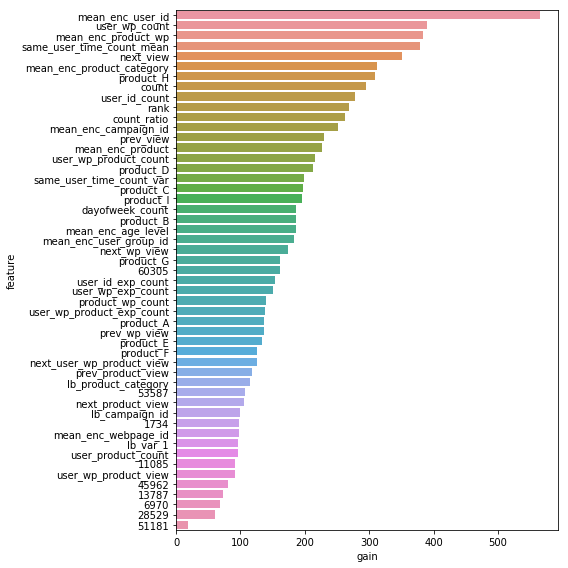

In [21]:
lgb_params = {
        'random_state':122,
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'logloss',
        'learning_rate': 0.03,
        'subsample': .4,
        'colsample_bytree': .8,
        'reg_alpha': 10,
        'reg_lambda': .01,
        'min_split_gain': 0.2,
        'min_child_weight': 10,
        'n_estimators': 1000,
        'silent': 1,
        'verbose': 1,
        'max_depth': 4
    }

clf = lgb.LGBMClassifier(**lgb_params)

y_val_preds_2day = val_check(clf, df_train, feats=feats, val_day=5)

(391825, 51)
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.240975	valid_1's binary_logloss: 0.225365
[200]	training's binary_logloss: 0.239288	valid_1's binary_logloss: 0.224615
[300]	training's binary_logloss: 0.238217	valid_1's binary_logloss: 0.224174
[400]	training's binary_logloss: 0.237403	valid_1's binary_logloss: 0.224013
[500]	training's binary_logloss: 0.236696	valid_1's binary_logloss: 0.223889
[600]	training's binary_logloss: 0.236102	valid_1's binary_logloss: 0.223819
[700]	training's binary_logloss: 0.235504	valid_1's binary_logloss: 0.223763
[800]	training's binary_logloss: 0.234936	valid_1's binary_logloss: 0.223709
[900]	training's binary_logloss: 0.234418	valid_1's binary_logloss: 0.223659
[1000]	training's binary_logloss: 0.233891	valid_1's binary_logloss: 0.223629
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.233891	valid_1's binary_logloss: 0.223629
AUC score: 0.648363624480741

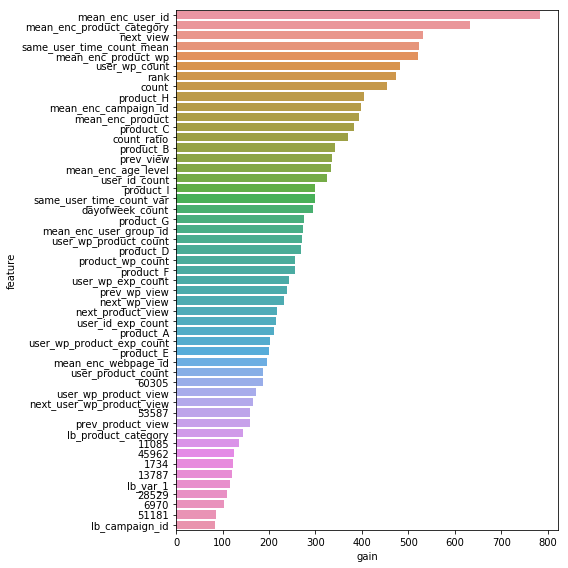

In [22]:
y_val_preds_1day = val_check(clf, df_train, feats, val_day=6)

In [23]:
lgb_params = {
        'random_state':11,
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'logloss',
        'learning_rate': 0.03,
        'subsample': .4,
        'colsample_bytree': .8,
        'reg_alpha': 10,
        'reg_lambda': .01,
        'min_split_gain': 0.2,
        'min_child_weight': 10,
        'n_estimators': 1200,
        'silent': 1,
        'verbose': 1,
        'max_depth': 4
    }

clf = lgb.LGBMClassifier(**lgb_params)

In [24]:
X = df_train
y = df_train['is_click']

feats = feats + ['next_view', 'next_user_wp_product_view', 'next_wp_view',
                                       'next_product_view']

X = get_next_view(X)[feats]
print(X.shape)

(463291, 51)


In [25]:
X_test = get_next_view(df_test)[feats]
X_test.shape

(128858, 51)

In [26]:
y_preds = []
for states in [1, 5, 11, 786, 122]:
    clf.set_params(**{'random_state': states})
    clf.fit(X, y, eval_set = [(X, y)], eval_metric = 'logloss', verbose = 200)
    y_preds_total = clf.predict_proba(X_test)[:, 1]
    y_preds.append(y_preds_total)

[200]	training's binary_logloss: 0.236985
[400]	training's binary_logloss: 0.235235
[600]	training's binary_logloss: 0.233991
[800]	training's binary_logloss: 0.232942
[1000]	training's binary_logloss: 0.231963
[1200]	training's binary_logloss: 0.23109
[200]	training's binary_logloss: 0.236968
[400]	training's binary_logloss: 0.235234
[600]	training's binary_logloss: 0.234001
[800]	training's binary_logloss: 0.232977
[1000]	training's binary_logloss: 0.231989
[1200]	training's binary_logloss: 0.231095
[200]	training's binary_logloss: 0.236959
[400]	training's binary_logloss: 0.235202
[600]	training's binary_logloss: 0.233977
[800]	training's binary_logloss: 0.232923
[1000]	training's binary_logloss: 0.23195
[1200]	training's binary_logloss: 0.231067
[200]	training's binary_logloss: 0.236959
[400]	training's binary_logloss: 0.235212
[600]	training's binary_logloss: 0.233999
[800]	training's binary_logloss: 0.232924
[1000]	training's binary_logloss: 0.231964
[1200]	training's binary_logl

In [27]:
from scipy.stats import gmean

In [28]:
y_preds_hm = gmean(y_preds)

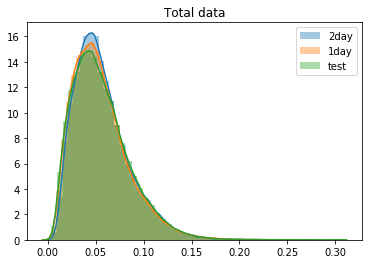

In [29]:
plt.figure()
sns.distplot(y_val_preds_2day, label = '2day')
sns.distplot(y_val_preds_1day, label = '1day')
sns.distplot(y_preds_hm, label = 'test')
plt.legend()
plt.title('Total data')
plt.show()

In [30]:
X = df_train.loc[df_train.DateTime.dt.day > 2]
y = df_train.loc[df_train.DateTime.dt.day > 2, 'is_click']

X = get_next_view(X)[feats]
print(X.shape)

(384246, 51)


In [31]:
lgb_params = {
        'random_state':11,
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'logloss',
        'learning_rate': 0.03,
        'subsample': .4,
        'colsample_bytree': .8,
        'reg_alpha': 10,
        'reg_lambda': .01,
        'min_split_gain': 0.2,
        'min_child_weight': 10,
        'n_estimators': 1000,
        'silent': 1,
        'verbose': 1,
        'max_depth': 4
    }

clf = lgb.LGBMClassifier(**lgb_params)

In [32]:
y_preds = []
for states in [1, 5, 11, 786, 122]:
    clf.set_params(**{'random_state': states})
    clf.fit(X, y, eval_set = [(X, y)], eval_metric = 'logloss', verbose = 200)
    y_preds_total = clf.predict_proba(X_test)[:, 1]
    y_preds.append(y_preds_total)

[200]	training's binary_logloss: 0.233892
[400]	training's binary_logloss: 0.232006
[600]	training's binary_logloss: 0.230638
[800]	training's binary_logloss: 0.22949
[1000]	training's binary_logloss: 0.22844
[200]	training's binary_logloss: 0.233927
[400]	training's binary_logloss: 0.232017
[600]	training's binary_logloss: 0.230694
[800]	training's binary_logloss: 0.22954
[1000]	training's binary_logloss: 0.228484
[200]	training's binary_logloss: 0.233912
[400]	training's binary_logloss: 0.232034
[600]	training's binary_logloss: 0.230701
[800]	training's binary_logloss: 0.229563
[1000]	training's binary_logloss: 0.228507
[200]	training's binary_logloss: 0.233898
[400]	training's binary_logloss: 0.232038
[600]	training's binary_logloss: 0.230693
[800]	training's binary_logloss: 0.229551
[1000]	training's binary_logloss: 0.228502
[200]	training's binary_logloss: 0.233912
[400]	training's binary_logloss: 0.232054
[600]	training's binary_logloss: 0.230672
[800]	training's binary_logloss: 

In [33]:
y_preds_hm_not2 = gmean(y_preds)

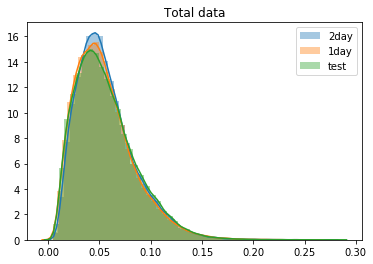

In [34]:
plt.figure()
sns.distplot(y_val_preds_2day, label = '2day')
sns.distplot(y_val_preds_1day, label = '1day')
sns.distplot(y_preds_hm_not2, label = 'test')
plt.legend()
plt.title('Total data')
plt.show()

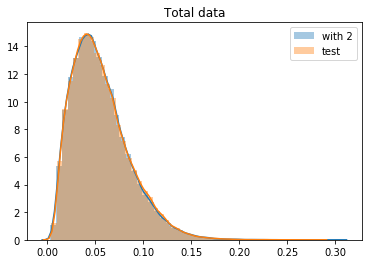

In [35]:
plt.figure()

sns.distplot(y_preds_hm, label = 'with 2')
sns.distplot(y_preds_hm_not2, label = 'test')
plt.legend()
plt.title('Total data')
plt.show()

In [36]:
y_preds = y_preds_hm_not2*0.6 + y_preds_hm*0.4

In [37]:
cat_preds = np.load(config.catboost_preds)

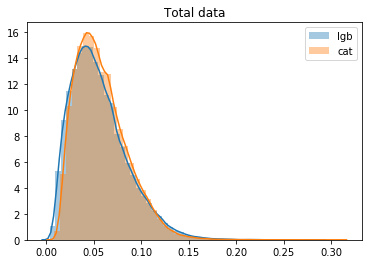

In [38]:
plt.figure()
sns.distplot(y_preds, label = 'lgb')
sns.distplot(cat_preds, label = 'cat')
plt.legend()
plt.title('Total data')
plt.show()

In [39]:
lgb_rank = pd.Series(y_preds).rank()
cat_rank = pd.Series(cat_preds).rank()

In [40]:
final_rank = lgb_rank * 0.8 + cat_rank * 0.2

In [41]:
final_sub = (final_rank - final_rank.min())/(final_rank.max() - final_rank.min())

In [42]:
submission = df_test[['session_id']]
submission['is_click'] = final_sub
submission.to_csv(config.submission, index = False)